
# DS6050 - Group 6
* Andrej Erkelens <wsw3fa@virginia.edu>
* Robert Knuuti <uqq5zz@virginia.edu>
* Khoi Tran <kt2np@virginia.edu>

## Abstract
English is a verbose language with over 69% redundancy in its construction, and as a result, individuals only need to identify important details to comprehend an intended message.
While there are strong efforts to quantify the various elements of language, the average individual can still comprehend a written message that has errors, either in spelling or in grammar.
The emulation of the effortless, yet obscure task of reading, writing, and understanding language is the perfect challenge for the biologically-inspired methods of deep learning.
Most language and text related problems rely upon finding high-quality latent representations to understand the task at hand. Unfortunately, efforts to overcome such problems are limited to the data and computation power available to individuals; data availability often presents the largest problem, with small, specific domain tasks often proving to be limiting.
Currently, these tasks are often aided or overcome by pre-trained large language models (LLMs), designed by large corporations and laboratories.
Fine-tuning language models on domain-specific vocabulary with small data sizes still presents a challenge to the language community, but the growing availability of LLMs to augment such models alleviates the challenge.
This paper explores different techniques to be applied on existing language models (LMs), built highly complex Deep Learning models, and investigates how to fine-tune these models, such that a pre-trained model is used to enrich a more domain-specific model that may be limited in textual data.

## Project Objective

We are aiming on using several small domain specific language tasks, particularly classification tasks.
We aim to take at least two models, probably BERT and distill-GPT2 as they seem readily available on HuggingFace and TensorFlow's model hub.
We will iterate through different variants of layers we fine tune and compare these results with fully trained models, and ideally find benchmarks already in academic papers on all of the datasets.

We aim to optimize compute efficiency and also effectiveness of the model on the given dataset. Our goal is to find a high performing and generalizable method for our fine tuning process and share this in our paper.


In [1]:
%autosave 0
import sys

Autosave disabled


In [2]:
if 'google.colab' in sys.modules:
    %pip install -q tensorflow-addons tensorflow-text tokenizers transformers
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/ds6050/git/

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt, nltk, numpy as np, os, \
       pandas as pd, re, seaborn as sns, string, tokenizers, \
       tensorflow as tf, tensorflow_addons as tfa, \
       tensorflow_text as tf_text, torch, transformers

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix


from tensorflow import keras
from tokenizers import decoders, models, normalizers, \
                       pre_tokenizers, processors, trainers

strategy = tf.distribute.MirroredStrategy()

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_feather("data/dataset.feather")#.set_index('index')
df['topic'] = df['topic'].str.split('.').str[0]
df_train = df.sample(frac = 0.8)
df_test = df.drop(df_train.index)

features = 'content' # feature for the future - add all the datasets ['categories', 'summary', 'content']
label = 'topic'

2022-08-09 02:10:31.003642: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/uqq5zz/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-08-09 02:10:35.664875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-09 02:10:37.817496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Create

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [4]:
# strategy = tf.distribute.MirroredStrategy()
ohe = OneHotEncoder()

# 7 different topics
# y_ = ohe.fit_transform(df['topic'].values.reshape(-1,1)).toarray()
y_train = ohe.fit_transform(df_train['topic'].values.reshape(-1,1)).toarray()
y_test  = ohe.fit_transform(df_test['topic'].values.reshape(-1,1)).toarray()

max_len = 512
checkpoint = 'gpt2'
hf_gpt2_tokenizer = transformers.GPT2TokenizerFast.from_pretrained(checkpoint, add_prefix_space=True)
# hf_gpt2_model = transformers.GPT2ForSequenceClassification.from_pretrained(checkpoint)

# add for gpt2 padding
if hf_gpt2_tokenizer.pad_token is None:
    hf_gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

## create model
def model_top(pretr_model):
    with strategy.scope():
        input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
        attention_mask = tf.keras.Input(shape=(max_len,), dtype='int32')

        output = pretr_model(input_ids = input_ids, attention_mask = attention_mask)
        # output = pretr_model([input_ids, attention_mask])
        #pooler_output = output[1]
        pooler_output = tf.keras.layers.AveragePooling1D(pool_size=max_len)(output[0])
        flattened_output = tf.keras.layers.Flatten()(pooler_output)

        output = tf.keras.layers.Dense(max_len, activation='tanh')(flattened_output)
        #output = tf.keras.layers.Dropout(0.2)(output)
        output = tf.keras.layers.Dropout(0.4)(output)

        output = tf.keras.layers.Dense(7, activation='softmax')(output)
        model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

train_encodings = hf_gpt2_tokenizer.batch_encode_plus(list(df_train.summary.values), 
                                                      return_tensors='tf', 
                                                      padding='max_length',
                                                      max_length = max_len,
                                                      truncation=True)

test_encodings  = hf_gpt2_tokenizer.batch_encode_plus(list(df_test.summary.values), 
                                                      return_tensors='tf', 
                                                      padding='max_length',
                                                      max_length = max_len,
                                                      truncation=True)

Using pad_token, but it is not set yet.


In [5]:
with strategy.scope():
    hf_gpt2_model = transformers.TFGPT2Model.from_pretrained(checkpoint)
    hf_gpt2_model.resize_token_embeddings(len(hf_gpt2_tokenizer))
    model = model_top(hf_gpt2_model)
model.summary()

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)        

In [6]:
model.layers

In [7]:
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tfgpt2_model (TFGPT2Model)     TFBaseModelOutputWi  124440576   ['input_1[0][0]',                
                                thPastAndCrossAtten               'input_2[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, 512, 76                                           

In [8]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Aug  9 02:10:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/

In [9]:
checkpoint_filepath = './tmp/checkpoint'

with strategy.scope():
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=1,
        mode="auto",
    )


    ds = tf.data.Dataset.from_tensor_slices((
        (train_encodings['input_ids'],
        train_encodings['attention_mask']),
        y_train)).with_options(options)
    
    ds_shuffle = ds.shuffle(buffer_size=512)
    ds_len = len(ds)
    train_size = np.floor(0.8*ds_len)
    ds_train = ds_shuffle.take(train_size).batch(32).with_options(options)
    ds_val = ds_shuffle.skip(train_size).batch(32).with_options(options)
    
    ds_y = [x[1].numpy() for x in ds_train]
    ds_y_train = np.concatenate(ds_y_train)
    
    history = model.fit(ds_train,
                        validation_data=ds_val,
                        epochs=8,
                        batch_size=max_len,
                        callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/8
INFO:tensorflow:batch_all_reduce: 150 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0

2022-08-09 02:11:55.470075: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-08-09 02:11:56.572881: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-08-09 02:11:57.268746: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-08-09 02:11:57.745044: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


901/901 [==============================] - 417s 397ms/step - loss: 1.4264 - accuracy: 0.5028 - val_loss: 0.9659 - val_accuracy: 0.6693
Epoch 2/8
901/901 [==============================] - 347s 385ms/step - loss: 0.8332 - accuracy: 0.7117 - val_loss: 0.9537 - val_accuracy: 0.6763
Epoch 3/8
901/901 [==============================] - 343s 381ms/step - loss: 0.6132 - accuracy: 0.7856 - val_loss: 1.0575 - val_accuracy: 0.6490


In [55]:
with strategy.scope():
    predict_train_data = model.predict(ds_train)
    pred_train_data = np.argmax(predict_train_data, axis = 1)
    train_cm = confusion_matrix(np.argmax(ds_y_train, axis = 1), pred_train_data)

901/901 [==============================] - 100s 111ms/step


In [56]:
ds_test = tf.data.Dataset.from_tensor_slices((
        (test_encodings['input_ids'],
        test_encodings['attention_mask']),
        y_test)).batch(32).with_options(options)

with strategy.scope():
    predict_test_data = model.predict(ds_test)
    pred_test_data = np.argmax(predict_test_data, axis = 1)
    test_cm = confusion_matrix(np.argmax(y_test, axis = 1), pred_test_data)

282/282 [==============================] - 32s 111ms/step


/tmp/ipykernel_3210/1031846850.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['','1','','','','2','','','','3']);


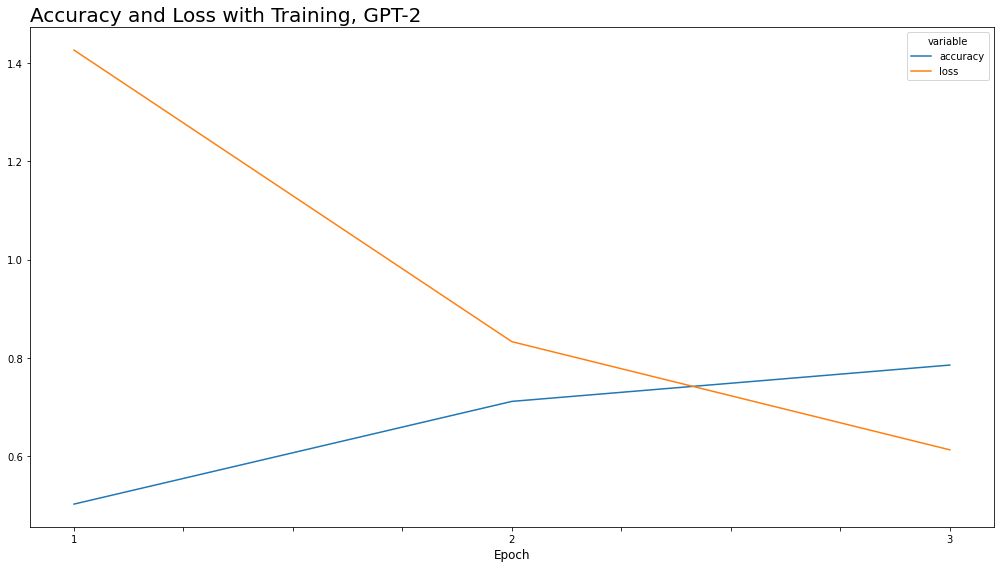

In [57]:
# plotting training history
history_df = pd.DataFrame(np.array([history.history['accuracy'], history.history['loss']]).T, columns = ['accuracy', 'loss'])
history_df = history_df.reset_index().rename(columns = {'index': 'epoch'})
history_df['epoch'] = history_df['epoch'] + 1
history_df = pd.melt(history_df, id_vars = 'epoch', value_vars = ['accuracy', 'loss'])

fig, ax = plt.subplots(1, 1, figsize = (14,8))
sns.lineplot(x = 'epoch', y = 'value', hue = 'variable', data = history_df);
# labels, title and ticks
ax.set_xlabel('Epoch', fontsize = 12);
ax.set_ylabel(''); 
ax.set_title('Accuracy and Loss with Training, GPT-2', loc = 'left', fontsize = 20); 
ax.xaxis.set_ticklabels(['','1','','','','2','','','','3']); 
plt.tight_layout()
plt.show()

282/282 [==============================] - 31s 111ms/step


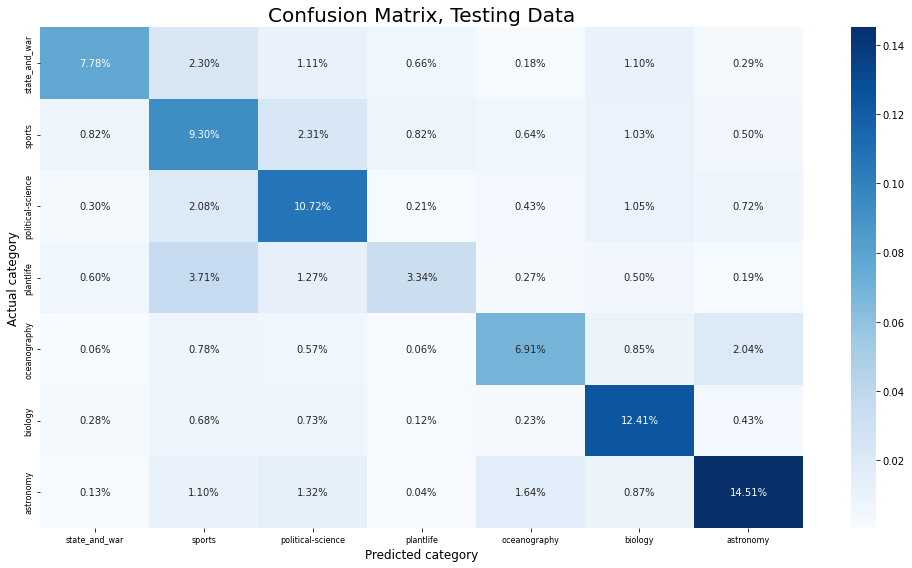

In [58]:
## creating confusion matrices
predict_train_data = model.predict(ds_train, batch_size=4)
pred_train_data = np.argmax(predict_train_data, axis = 1)
train_cm = confusion_matrix(np.argmax(ds_y_train, axis = 1), pred_train_data)

test_ds = tf.data.Dataset.from_tensor_slices((
    (test_encodings['input_ids'],
    test_encodings['attention_mask']),
    y_test)).batch(32).with_options(options)

predict_test_data = model.predict(test_ds)
pred_test_data = np.argmax(predict_test_data, axis = 1)
test_cm = confusion_matrix(np.argmax(y_test, axis = 1), pred_test_data)

labels = list(df['topic'].unique())
labels.sort()
x_labs = labels
labels.sort(reverse = True)
y_labs = labels

def plot_cm(cm, title = 'Confusion Matrix'):
  fig, ax = plt.subplots(1, 1, figsize = (14,8))
  sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');
  # labels, title and ticks
  ax.set_xlabel('Predicted category', fontsize = 12);
  ax.set_ylabel('Actual category', fontsize = 12); 
  ax.set_title(title, fontsize = 20); 
  ax.xaxis.set_ticklabels(x_labs, fontsize = 8); 
  ax.yaxis.set_ticklabels(y_labs, fontsize = 8);
  plt.tight_layout()
  plt.show()

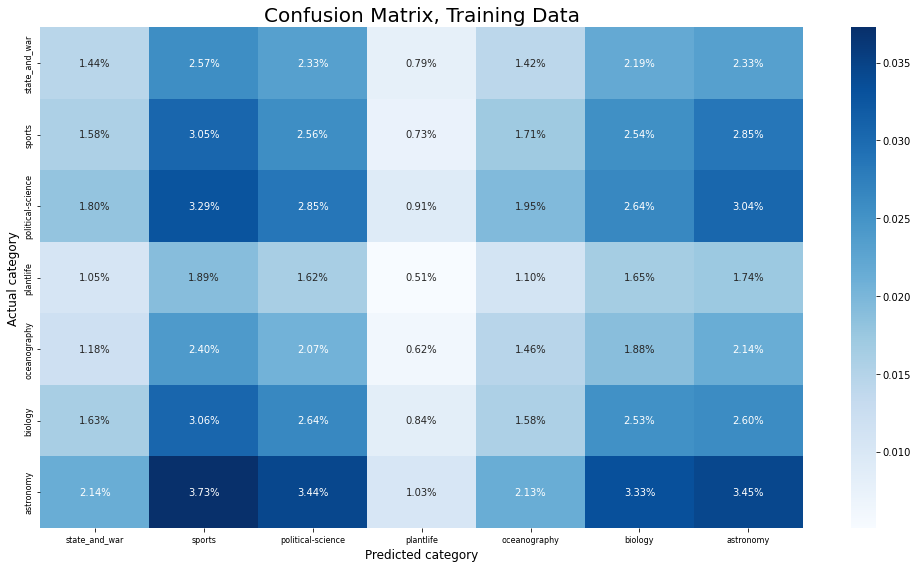

In [65]:
plot_cm(train_cm, 'Confusion Matrix, Training Data')

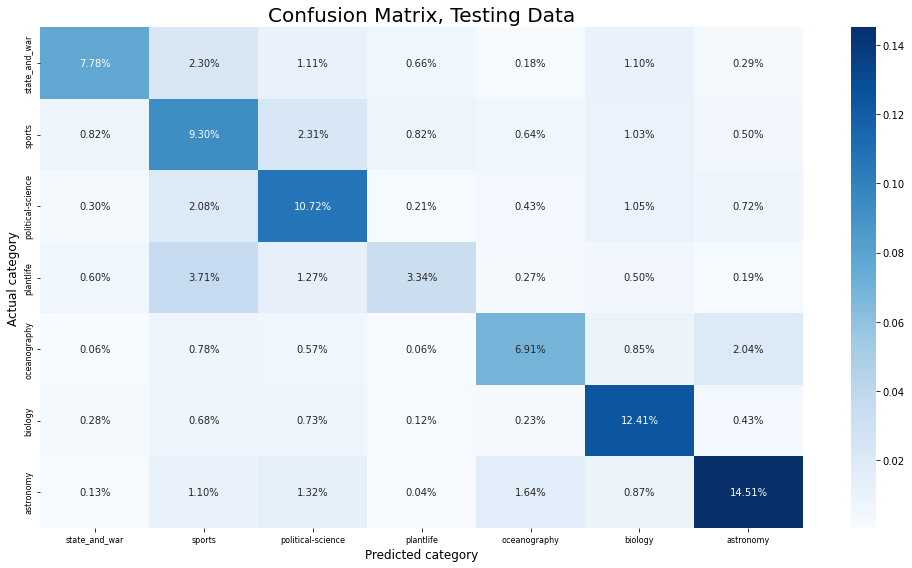

In [60]:
plot_cm(test_cm, 'Confusion Matrix, Testing Data')

In [61]:
# evaluating with non-fine tuned pretrained GPT-2 model

bat_size=32

with strategy.scope():
    model_untr = model_top(hf_gpt2_model)
    untr_pred_train = model_untr.predict(ds_train, 
                                         batch_size=bat_size)
    untr_train_cm = confusion_matrix(np.argmax(ds_y_train, axis = 1), 
                                     np.argmax(untr_pred_train, axis = 1))

    untr_pred_test = model_untr.predict(ds_test, 
                                        batch_size=bat_size)
    untr_test_cm = confusion_matrix(np.argmax(y_test, axis = 1), 
                                    np.argmax(untr_pred_test, axis = 1))

282/282 [==============================] - 32s 111ms/step


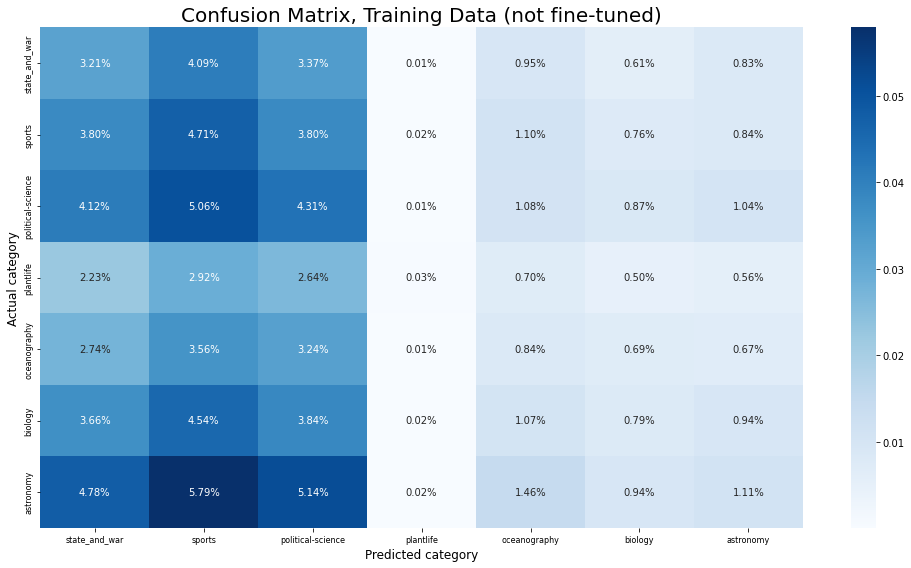

In [62]:
plot_cm(untr_train_cm, 'Confusion Matrix, Training Data (not fine-tuned)')

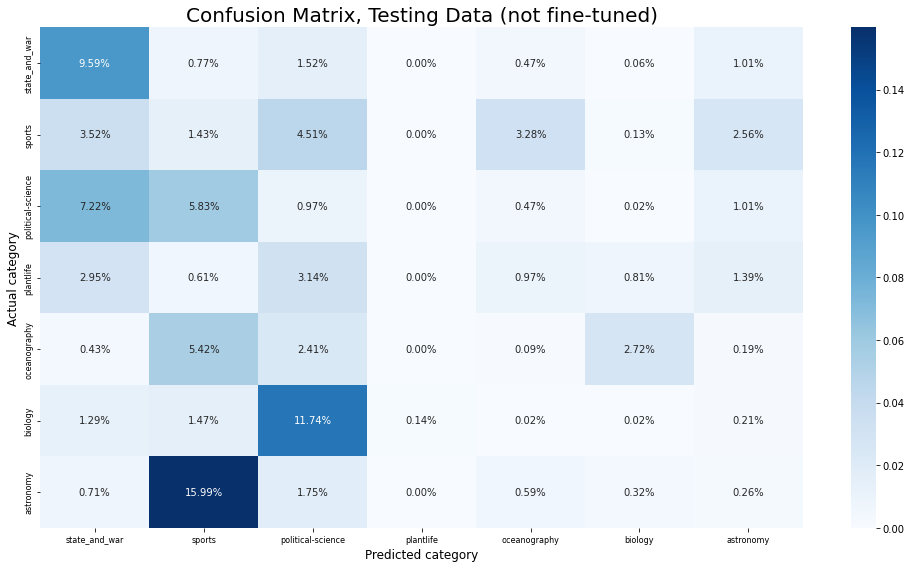

In [63]:
plot_cm(untr_test_cm, 'Confusion Matrix, Testing Data (not fine-tuned)')

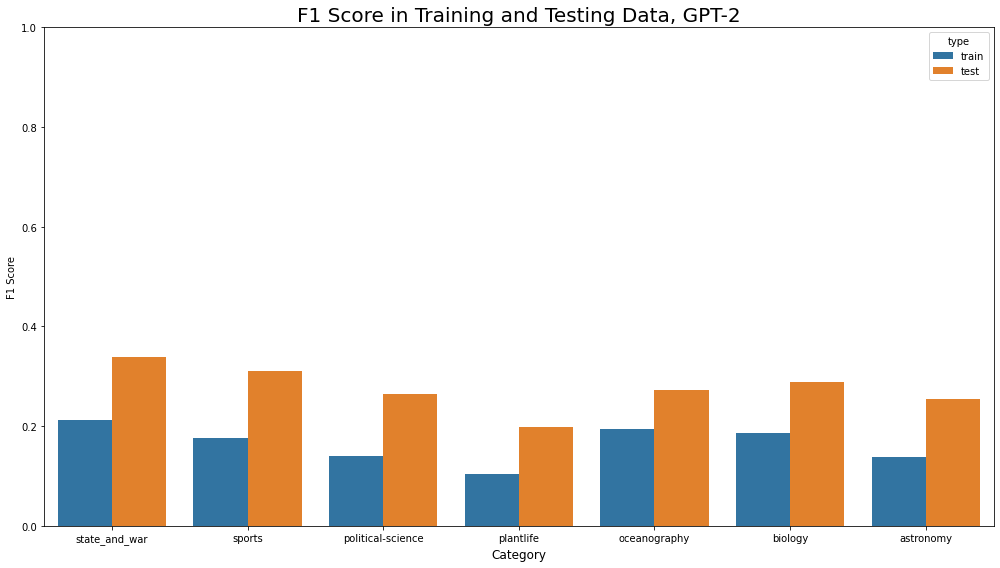

In [67]:
# see f1 scores
# threshold is just median/mean rounded up to the nearest 0.15
f1_metric = tfa.metrics.F1Score(num_classes = 7, threshold = 0.15)
f1_metric.update_state(ds_y_train, predict_train_data)
train_f1 = f1_metric.result()
f1_metric.update_state(y_test, predict_test_data)
test_f1 = f1_metric.result()

# turn to dataframe
train_f1 = pd.Series(train_f1.numpy()).reset_index().rename(columns = {'index': 'category', 0: 'f1'})
train_f1['type'] = 'train'
test_f1  = pd.Series(test_f1.numpy()).reset_index().rename(columns  = {'index': 'category', 0: 'f1'})
test_f1['type']  = 'test'

gpt2_f1 = pd.concat([train_f1, test_f1]).reset_index(drop = True)\
            .replace({'category': {t: idx for idx, t in zip(sorted(df['topic'].unique()), range(7))}})\
            .sort_values(by = ['category', 'type'], ascending = False)

# plotting
plt.figure(figsize = (14,8))
# can't get it to sort alphabetically for some reason
ax = sns.barplot(x = 'category', y = 'f1', hue = 'type', data = gpt2_f1, order = list(set(gpt2_f1.category)));
# labels, title and ticks
ax.set_xlabel('Category', fontsize = 12);
ax.set_ylabel('F1 Score'); 
ax.set_title('F1 Score in Training and Testing Data, GPT-2', fontsize = 20); 
ax.xaxis.set_ticklabels(labels); 
ax.set_ylim([0, 1]);
plt.tight_layout()
plt.show()

In [68]:
## visualizing model architecture
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_gpt2_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
plot_model(model_untr, to_file='model_untr_gpt2_plot.png', show_shapes=True, show_layer_names=True)